In [117]:
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import medfilt
import cartopy.crs as crs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import netCDF4 as nc
plt.rcParams.update({
    "text.usetex": True,                # Enable LaTeX text rendering
    "font.family": "serif",             # Use a serif font
    "font.serif": ["Computer Modern"],  # Set font to Computer Modern (LaTeX default)
})
sys.path.append('../src/')
from Biologging_Toolkit.applications.Jerk import Jerk
from Biologging_Toolkit.utils.plot_utils import subplots_centered
import warnings
warnings.filterwarnings("ignore")

## Get map of detections per deployment

In [118]:
depid = 'ml19_293a'
ds_path = 'D:/individus_brut/individus'
annotation_path = 'D:/drift_dives_SES/'

In [123]:
ds = nc.Dataset(os.path.join(ds_path, depid, depid+'_sens.nc'))
dive = pd.read_csv(os.path.join(ds_path, depid, depid+'_dive.csv'))
annot = pd.read_csv(os.path.join(annotation_path, depid, 'timestamps.csv'))

In [124]:
def successive_detections(series):
    changes = series.diff().fillna(0)
    starts = changes == 1 
    ends = changes == -1
    cumulative = series.cumsum() 
    lengths = cumulative[ends].diff().fillna(cumulative[ends]) 
    result = np.zeros_like(series)
    result[ends[ends].index] = lengths.values
    return pd.Series(result, index=series.index)
def sliding_window_sum(time_series, N):
    result = np.zeros_like(time_series)
    for i in range(len(time_series) - N + 1):
        result[i + N - 1] = np.sum(time_series[i:i + N])
    return result

In [125]:
labels = np.unique(np.concatenate([annot[col].dropna() for col in ['Annotation','Annotation2','Annotation3']]))
annot_pos = np.searchsorted(dive.begin_time, annot.start_drift)-1
annotations = {label : np.zeros(len(dive)) for label in labels}
'''annotations = {'Blue whale':np.zeros(len(dive))
               'Antarctic blue whale':np.zeros(len(dive)),
               'Sperm whale':np.zeros(len(dive)),
               'Sei whale':np.zeros(len(dive)),
               'Humpback whale':np.zeros(len(dive)),
               'Fin whale':np.zeros(len(dive)),
               'Minke whale':np.zeros(len(dive))}'''
print(labels)

['Antarctic Blue Whale' 'Delphinid click' 'Southern Right Whales'
 'Spermwhale' 'Unknown buzz' 'Unknown clicks']


In [126]:
idx = 1
for i, row in annot.iterrows() :
    det = row[['Annotation', 'Annotation2', 'Annotation3']].to_numpy()
    conf = row[['Indice', 'Indice2', 'Indice3']].to_numpy()
    det = det[conf >= idx]
    for _det in det :
        if _det in ['Antarctic blue whale', 'Dcall', 'Blue whale'] :
            annotations['Antarctic blue whale'][annot_pos[i]] = 1
        elif _det=='Minke whale':
            annotations['Minke whale'][annot_pos[i]] = 1
        elif _det=='Spermwhale':
            annotations['Spermwhale'][annot_pos[i]] = 1
        elif _det=='Fin whale':
            annotations['Fin whale'][annot_pos[i]] = 1
        elif _det=='Humpback whale':
            annotations['Humpback whale'][annot_pos[i]] = 1
        elif _det=='Sei whale':
            annotations['Sei whale'][annot_pos[i]] = 1
        elif _det in['Odontocete clicks', 'Odontocete buzz', 'Odontocete whistle'] :
            annotations['Odontocete clicks'][annot_pos[i]] = 1
annotations = pd.DataFrame(annotations)
for key in list(annotations.keys()) :
    dive[key] = successive_detections(annotations[key])

In [127]:
baleen_whales = ['Antarctic Blue Whale', 'Antarctic blue whale', 'Blue whale ', 'Dcall', 'Downsweep', 'Fin whale',
                 'Humpback whale', 'Minke whale', 'Sei whale', 'Southern Right Whale', 'Southern Right Whales']
odontocetes = ['Buzz', 'Clicks', 'Delphinid click', 'Ind clicks 18kHz', 'Odontocete buzz', 'Odontocete clicks',
               'Odontocete whistle', 'Spermwhale', 'Unidentified clicks', 'Unindentified clicks',
               'Unindentified whistle', 'Unknown buzz', 'Unknown clicks', 'delphinid click', 'delphinid whistle']

In [128]:
dive['baleen'] = dive[dive.columns[np.isin(dive.columns, baleen_whales)]].sum(axis = 1)
dive['odontocetes'] = dive[dive.columns[np.isin(dive.columns, odontocetes)]].sum(axis = 1)

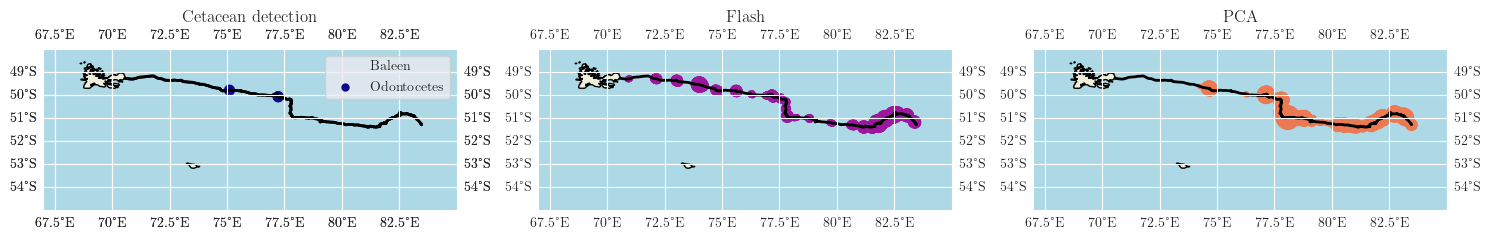

In [131]:
proxy = {"Flash":"flash", "PCA":"total_jerk"}
#columns = list(dive[annotations.columns].sum()[dive[annotations.columns].sum() > 0].index)
columns = ['baleen', 'odontocetes']
fig, ax = plt.subplots(1,3, figsize=(15, 5), subplot_kw={'projection': crs.PlateCarree()})
for key in proxy.keys() :
    _temp = sliding_window_sum(dive[proxy[key]], 10)
    dive[key] = (_temp - np.nanmean(_temp)) / np.nanstd(_temp)
    columns.append(key)

colors = colormaps.get_cmap('plasma').resampled(len(columns))
for i, elem in enumerate(columns) :
    if np.isin(elem, ['baleen', 'odontocetes']) :
        j = 0
        _label = 'Cetacean detection'
    else :
        j = i-1
        _label = elem
    ax[j].set_extent([67, 85, -48, -55], crs=crs.PlateCarree())  # Adjust the limits as needed
    ax[j].plot(dive.lon, dive.lat, c = 'k', linewidth = 2)
    ax[j].scatter(dive.lon, dive.lat, s = dive[elem] * 50, c = colors((i-1)%4), label = elem.capitalize())
    if j == 0:
        ax[j].legend()
    ax[j].add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax[j].add_feature(cfeature.LAND, edgecolor='black')
    #ax[j].add_feature(cfeature.COASTLINE)
    #ax[j].add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
    ax[j].gridlines(draw_labels=True)
    ax[j].set_title(_label)
fig.tight_layout()

In [132]:
fig.savefig("C:/Users/grosmaan/Desktop/Results/ml19_293a_whales.pdf")

## Map / Bubble plot of cetacean detections and PCA

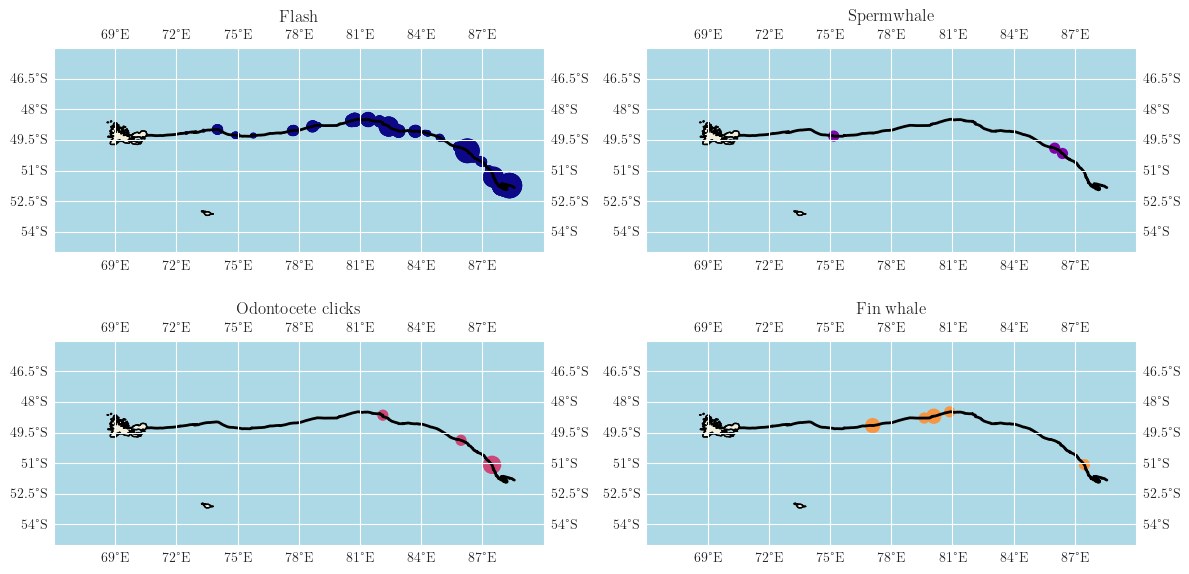

In [9]:
proxy = {"Flash":"flash"}
fig, ax = plt.subplots(2, 2, figsize=(12, 6), subplot_kw={'projection': crs.PlateCarree()})
ax = ax.flatten()
columns = list(dive[annotations.columns].sum()[dive[annotations.columns].sum() > 0].index)
_temp = sliding_window_sum(dive[list(proxy.values())[0]], 10)
dive[list(proxy.keys())[0]] = (_temp - np.nanmean(_temp)) / np.nanstd(_temp)
columns.append(list(proxy.keys())[0])
colors = colormaps.get_cmap('plasma').resampled(len(columns))
for i, elem in enumerate(columns[::-1][-5:-1]) :
    ax[i].set_extent([66, 90, -45, -55], crs=crs.PlateCarree())  # Adjust the limits as needed
    ax[i].plot(dive.lon, dive.lat, c = 'k', linewidth = 2, label = elem)
    ax[i].scatter(dive.lon, dive.lat, s = dive[elem] * 50, c = colors(i))
    ax[i].add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax[i].add_feature(cfeature.LAND, edgecolor='black')
    ax[i].add_feature(cfeature.COASTLINE)
    ax[i].add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
    ax[i].gridlines(draw_labels=True)
    ax[i].set_title(f"{elem}")
fig.tight_layout()

In [ ]:
len(columns)

In [ ]:
fig.savefig("C:/Users/grosm/Desktop/thèse/Figures/whale/map_comparison_ml18_294b.pdf")

## Plot of temporal series

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))
dive["begin_time"] = pd.to_datetime(dive["begin_time"], unit="s")
columns = list(dive[annotations.columns].sum()[dive[annotations.columns].sum() > 0].index)
colors = colormaps.get_cmap('viridis').resampled(len(columns))
ax1 = ax.twinx()
ax.scatter(dive.begin_time[dive.total_jerk > 0], dive.total_jerk[dive.total_jerk > 0], 
           alpha = 0.2, c = 'orange', label = 'PCA')
ax.plot(dive.begin_time, medfilt(dive.total_jerk, 101), c = 'orange', label = 'median PCA')
for i, elem in enumerate(columns[::-1]) :
    ax1.plot(dive.begin_time, dive[elem], c = colors(i), linewidth = 3, label = elem)
ax.set_facecolor('whitesmoke')
ax1.grid()
ax.tick_params(axis='x', rotation=45)
handles_ax, labels_ax = ax.get_legend_handles_labels()
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
legend = ax.legend(handles_ax + handles_ax1, labels_ax + labels_ax1, loc="upper left")
ax.set_ylabel("Number of prey catch attempts (PCA)")
ax1.set_ylabel("Number of recordings with detection")

In [ ]:
fig.savefig("C:/Users/grosm/Desktop/thèse/Figures/")

## Pooling detections

In [3]:
depids = ['ml17_280a', 'ml18_296a', 'ml18_294b', 'ml19_292a', 'ml19_292b', 'ml19_293a', 'ml19_294a', 'ml20_293a', 'ml20_296b', 'ml20_313a', 'ml21_295a', 'ml21_305b']

In [51]:
detections = pd.DataFrame()
eleph = pd.DataFrame()
for depid in depids[:7]:
    eleph = pd.concat((eleph, pd.read_csv(os.path.join(ds_path, depid, f'{depid}_dive.csv'))))
    try:
        annot = pd.read_csv(os.path.join(annotation_path, depid, 'timestamps.csv'), delimiter=',')
        if annot.shape[1] == 1:
            raise ValueError("Probably wrong delimiter")
    except:
        annot = pd.read_csv(os.path.join(annotation_path, depid, 'timestamps.csv'), delimiter=';')
    _annot = annot[['start_drift', 'end_drift', 'lat', 'lon', 'orig_fn', 'start_fn', 'fn','Annotation', 'Time', 'Indice', 'Notes']]
    detections = pd.concat((detections, _annot))
    _annot = annot[['start_drift', 'end_drift', 'lat', 'lon', 'orig_fn', 'start_fn', 'fn','Annotation2', 'Time2', 'Indice2', 'Notes2']]
    _annot.columns = ['start_drift', 'end_drift', 'lat', 'lon', 'orig_fn', 'start_fn', 'fn','Annotation', 'Time', 'Indice', 'Notes']
    detections = pd.concat((detections, _annot))
    _annot = annot[['start_drift', 'end_drift', 'lat', 'lon','orig_fn', 'start_fn', 'fn','Annotation3', 'Time3', 'Indice3', 'Notes3']]
    _annot.columns = ['start_drift', 'end_drift', 'lat', 'lon', 'orig_fn', 'start_fn', 'fn','Annotation', 'Time', 'Indice', 'Notes']
    detections = pd.concat((detections, _annot))


In [52]:
labels = [str(label) for label in np.unique(list(detections['Annotation']))]
print(labels)

['10 Hz sound', 'Antarctic Blue Whale', 'Antarctic blue whale', 'Blue whale ', 'Boat', 'Buzz', 'Clicks', 'Dcall', 'Delphinid click', 'Downsweep', 'Fin whale', 'Fish', 'Flow noise', 'Grattage', 'Humpback whale', 'Ind 150Hz', 'Ind 150Hz + 300 Hz', 'Ind 150Hz + 40 Hz', 'Ind 350Hz', 'Ind 40 Hz', 'Ind 400', 'Ind 40Hz', 'Ind 60 Hz', 'Ind clicks 18kHz', 'Minke whale', 'Odontocete buzz', 'Odontocete clicks', 'Odontocete whistle', 'STOP', 'Sei whale', 'Southern Right Whale', 'Southern Right Whales', 'Spermwhale', 'Sweep', 'Tir sismique', 'Unidentified clicks', 'Unindentified clicks', 'Unindentified whistle', 'Unknown', 'Unknown buzz', 'Unknown clicks', 'Unknown double pulse', 'delphinid click', 'delphinid whistle', 'nan']


In [53]:
baleen_whales = ['Antarctic Blue Whale', 'Antarctic blue whale', 'Blue whale ', 'Dcall','Downsweep', 'Fin whale','Humpback whale', 'Minke whale', 'Sei whale', 'Southern Right Whale', 'Southern Right Whales']

In [54]:
odontocetes = ['Buzz', 'Clicks', 'Delphinid click', 'Ind clicks 18kHz', 'Odontocete buzz', 'Odontocete clicks', 'Odontocete whistle', 'Spermwhale', 'Unidentified clicks', 'Unindentified clicks', 'Unindentified whistle', 'Unknown buzz', 'Unknown clicks','delphinid click', 'delphinid whistle']

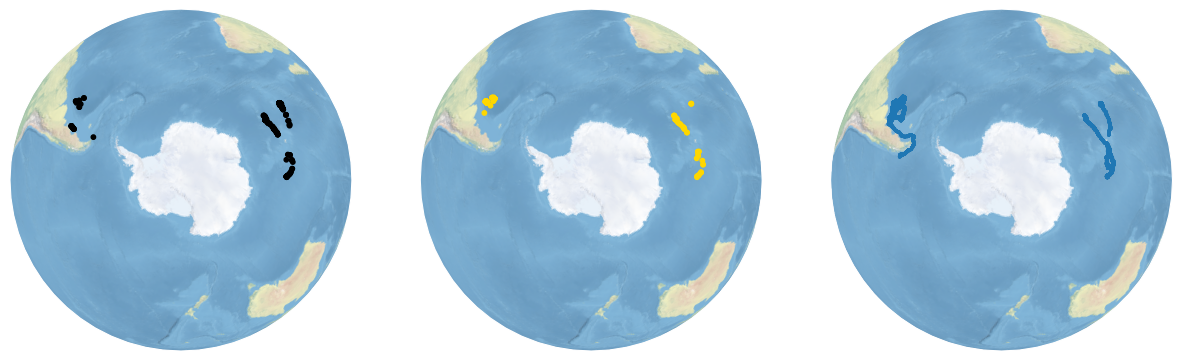

In [55]:
baleen = detections[np.isin(detections['Annotation'], baleen_whales)]
odontocetes = detections[np.isin(detections['Annotation'], odontocetes)]
fig, ax = plt.subplots(1,3, figsize=(15,5), subplot_kw={'projection': crs.Orthographic(central_latitude=-90, central_longitude=0)})
ax = ax.flatten()
for i, _ax in enumerate(ax) :
    _ax.stock_img()
    if i == 0:
        _ax.scatter(x=baleen.lon, y=baleen.lat, s=10*np.ones(len(baleen)), c='black', transform=crs.PlateCarree())
    elif i == 1:
        _ax.scatter(x=odontocetes.lon, y=odontocetes.lat, s=10*np.ones(len(odontocetes)), c = 'gold', transform=crs.PlateCarree())
    elif i == 2:
        _ax.scatter(x=eleph.lon, y=eleph.lat, s= np.log(eleph.flash), transform=crs.PlateCarree())
fig.show()

In [56]:
baleen['timestamp'] = pd.to_datetime(baleen['start_drift'], unit='s')
baleen['baleen'] = np.ones(len(baleen))
odontocetes['timestamp'] = pd.to_datetime(odontocetes['start_drift'], unit='s')
odontocetes['odontocetes'] = np.ones(len(odontocetes))
eleph['timestamp'] = pd.to_datetime(eleph['begin_time'], unit='s')
baleen['date'] = baleen['timestamp'].dt.date
odontocetes['date'] = odontocetes['timestamp'].dt.date
eleph['date'] = eleph['timestamp'].dt.date
eleph = eleph[['date', 'flash', 'total_jerk']]
baleen = baleen[['date', 'baleen']]
odontocetes = odontocetes[['date', 'odontocetes']]

In [57]:
odontocetes = odontocetes.groupby('date').agg({'odontocetes': 'sum'}).reset_index()
baleen = baleen.groupby('date').agg({'baleen': 'sum'}).reset_index()
eleph = eleph.groupby('date').agg({'total_jerk': 'sum', 'flash':'sum'}).reset_index()

In [58]:
merged_df = pd.merge(odontocetes, baleen, on='date', how='outer')
final_df = pd.merge(merged_df, eleph, on='date', how='outer')
#final_df = merged_df.groupby('date').agg({
#    'flash': 'sum',
#    'baleen': 'sum',
#    'odontocetes' : 'sum',
#    'total_jerk':'sum'
#}).reset_index()

In [1]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].scatter(final_df.total_jerk, final_df.baleen, alpha = 0.8, c = 'crimson')
ax[0].scatter(final_df.total_jerk, final_df.odontocetes, alpha = 0.8, c = 'powderblue')
ax[1].scatter(final_df.flash, final_df.baleen, alpha = 0.8, c = 'crimson')
ax[1].scatter(final_df.flash, final_df.odontocetes, alpha = 0.8, c = 'powderblue')
ax[1].set_xscale('log')


NameError: name 'plt' is not defined

In [26]:
final_df

,date,flash,baleen,odontocetes,total_jerk
23,2017-10-30,17295.0,1050.0,1050.0,13515
37,2018-10-27,5866.0,1120.0,1120.0,4172
39,2018-10-29,3954.0,462.0,462.0,4032
41,2018-10-31,6342.0,984.0,984.0,2292
42,2018-11-01,19800.0,2808.0,2808.0,8154
44,2018-11-03,3850.0,1001.0,1001.0,2849
45,2018-11-04,3936.0,636.0,636.0,3152
46,2018-11-05,2274.0,462.0,462.0,879
47,2018-11-06,2432.0,596.0,596.0,1420
49,2018-11-08,11055.0,1661.0,1661.0,6996
